# Imports and data loading


In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184097 sha256=4214d469125724cae1e266e66b4764f60fc0bb56a9ec730e788a709be1d1bb98
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
Successfully built pyod


In [ ]:
!pip install pyhf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3


In [ ]:
import pyhf
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import sys
import math
import random
import timeit
import seaborn as sns
sns.set_style("white")
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Since we dont have RAM capacity to read the entire Background file we will choose randomly 1500000 events from the file

In [ ]:
def sample_n_from_csv(filename:str, n:int=100, total_rows:int=None) -> pd.DataFrame:
    if total_rows==None:
        with open(filename,"r") as fh:
            total_rows = sum(1 for row in fh)
    if(n>total_rows):
        print("Error: n > total_rows", file=sys.stderr)
    skip_rows =  random.sample(range(1,total_rows+1), total_rows-n)
    return pd.read_csv(filename, skiprows=skip_rows)

In [ ]:
Signal = pd.read_csv("/content/drive/MyDrive/MASH/ResmMed4000mX1lb0p2yp0p4.csv")
Background = sample_n_from_csv("/content/drive/MyDrive/MASH/bkg.csv", n=1500000)

# Feature representation

    The ones containing Weight are related to the statistical weight of simulated events (to normalise a given sample to the expected number of events for that process)
    'eventNumber', 'mcChannelNumber', 'mc_channel', 'gen_sample', 'merge_sample': are identifiers of the simulated process
    'nLumi' is the integrated luminosity of the real data
    'mu', 'mu_actual' are related with the number of simultaneous collisions (pile-up)
    'gen_split' é uma variável que separa os dados em três categorias: train, val e test para usar em treino, validação e teste dos modelos de machine learning, respectivamente.

As variáveis anteriores não devem ser utilizadas como input dos métodos de machine learning. Para tal usam-se variáveis que descrevem a cinemática do acontecimento:

    Prefix jet_* = jet, ljet_* = large jet and fjet_* = forward jet (|eta| > 2.5)
    Sufix *_pt, *_eta , *_phi and *_e define the 4-momentum of the object (jet, ljet, etc...)
    Sufix *_px, *_py , *_pz and *_e define the 4-momentum of the object (jet, ljet, etc...) in cartesian coordinates
    DL1r is the output of the b-tagging algorithm
    MET missing transverse energy
    Prefix Delta refers to the difference in a given quantity, for instance in energy or Pt, between two objects
    'Centrality', 'Centrality2', 'Centrality3' are a measure of the isotropy of the energy distribution in the event
    Prefix n = number
    mtop = top candidate mass
    HT = scalar Pt sum of all objects in the event
    MT_JMET = Transverse mass of the ljet+MET system



Labelling and concatenating data

In [ ]:
Signal['label']  = 1
Background['label']   = 0

# Concatenate all the samples
data = pd.concat([Signal, Background],ignore_index=True)

In [ ]:
features = Signal.columns
features

Index(['Unnamed: 0', 'combinedWeight', 'eventNumber', 'mu', 'mu_actual',
       'mcChannelNumber', 'MET', 'MET_Phi', 'isOdd', 'isBlind', 'nGoodJets',
       'nGoodbJets', 'nGoodlJets', 'nGoodtoplJets', 'nForwardJets',
       'nTruthJets', 'jet_pt', 'jet_e', 'jet_eta', 'jet_phi', 'ljet_pt',
       'topjet_pt', 'ljet_e', 'topjet_e', 'ljet_m', 'topjet_m', 'ljet_eta',
       'topjet_eta', 'ljet_phi', 'topjet_phi', 'fjet_pt', 'fjet_e', 'fjet_eta',
       'fjet_phi', 'DeltaPhi_MET_ljet', 'Omega', 'DeltaPhi_MET_calojets',
       'MT_JMET', 'HT', 'mtop', 'DeltaPt_top_jets', 'DeltaE_top_jets',
       'DeltaPt_top_jetsbjet', 'DeltaE_top_jetsbjet', 'DeltaE_tot',
       'DeltaPhi_bjet_topjet', 'Centrality', 'Centrality2', 'Centrality3',
       'DeltaR_max', 'MT_bMET_min', 'DeltaR_bjet_topjet', 'DeltaPhi_MET_fjet',
       'DeltaPhi_fjet_calojets', 'DeltaPt_fjet_jets', 'DeltaPt_fjet_bjet',
       'DeltaPt_fjet_top', 'DeltaE_fjet_jets', 'DeltaE_fjet_jetsbjet',
       'DeltaR_fjet_topjet', 'DeltaR_bje

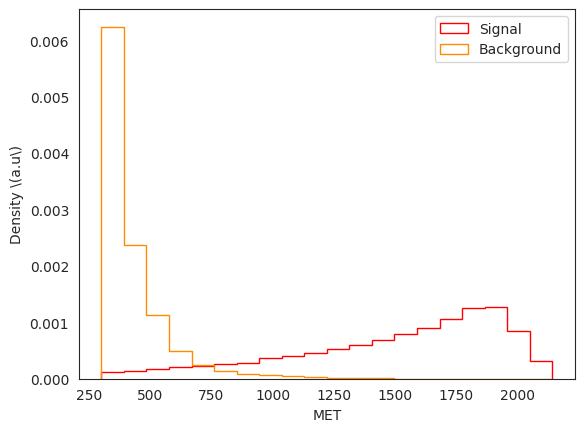

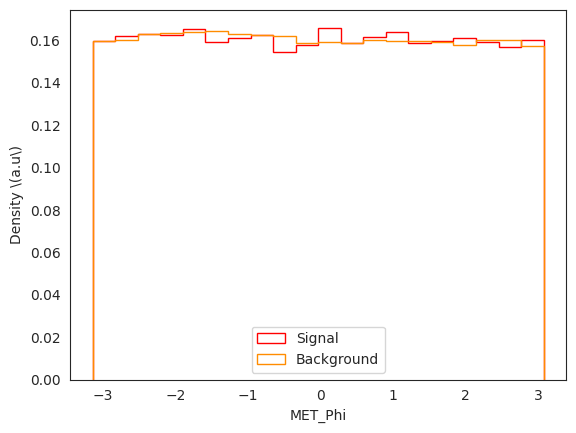

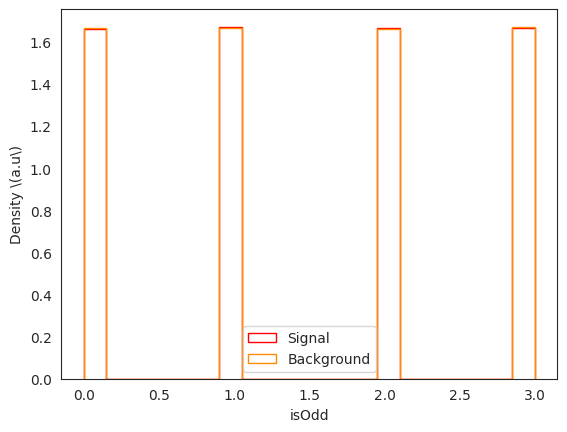

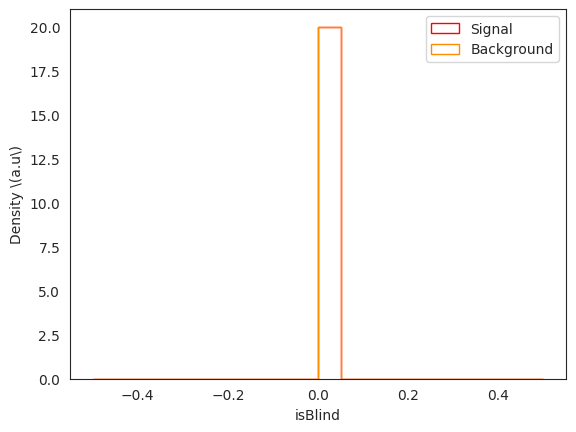

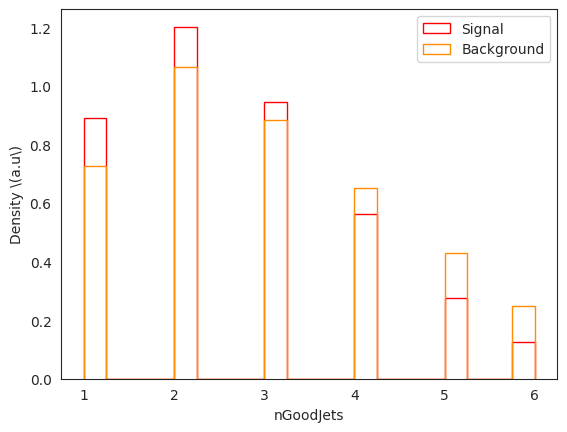

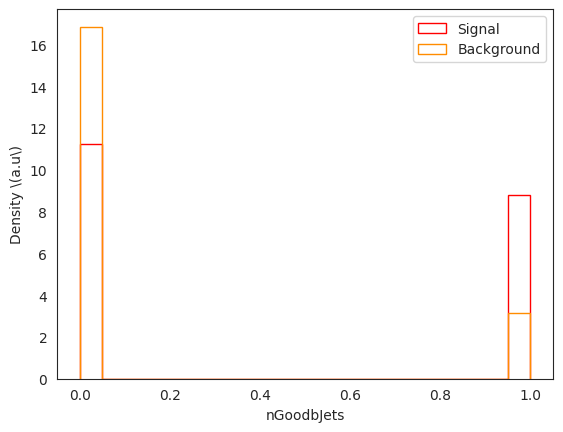

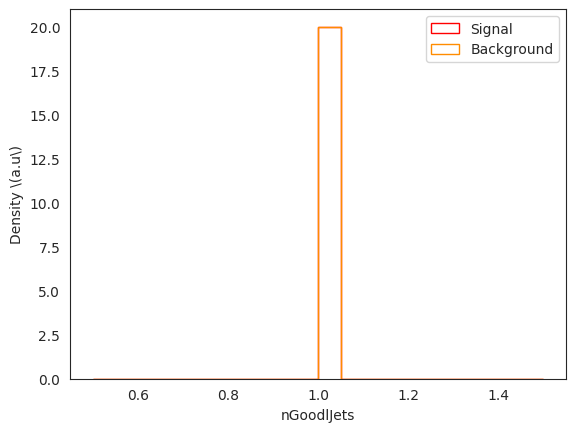

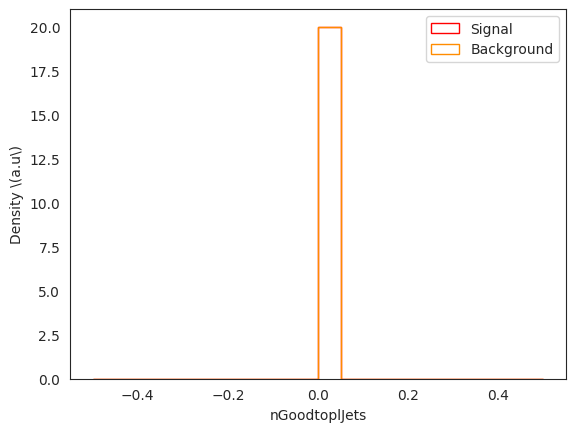

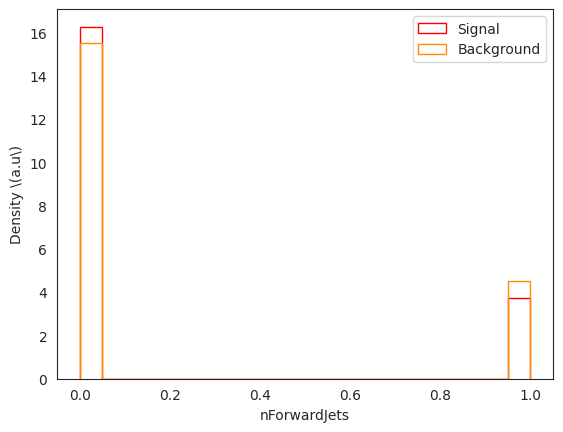

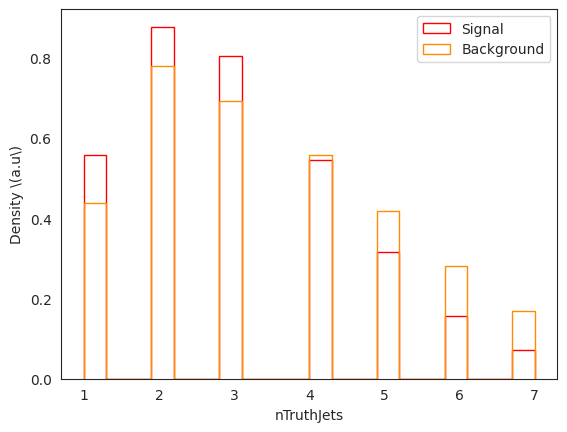

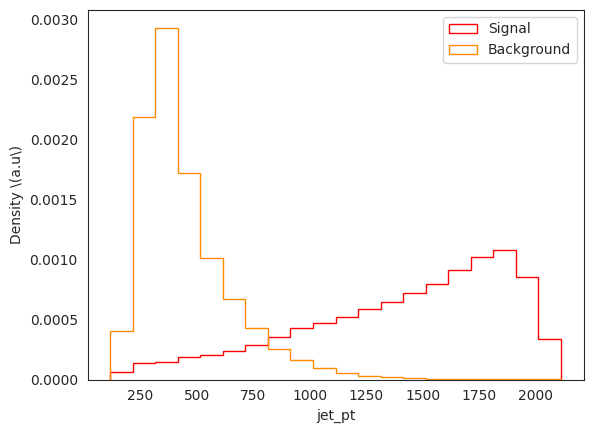

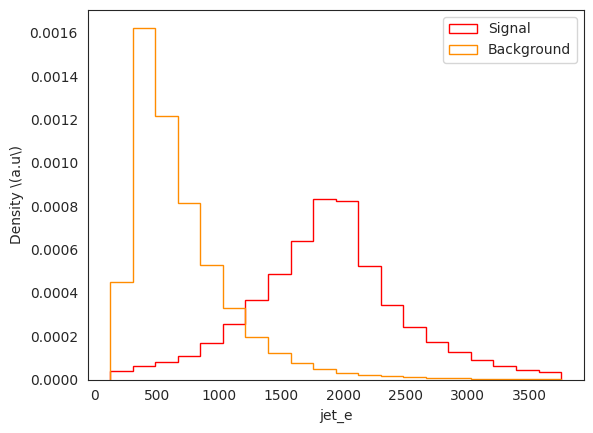

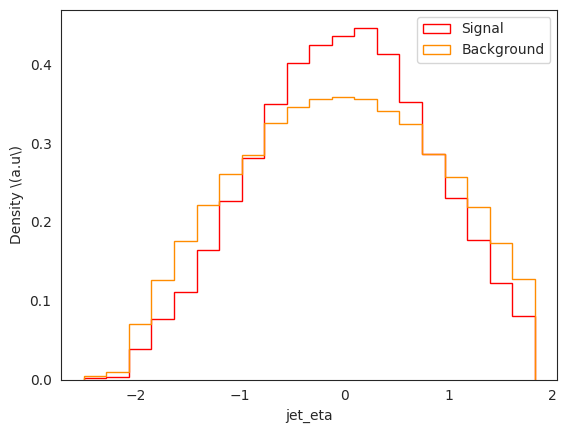

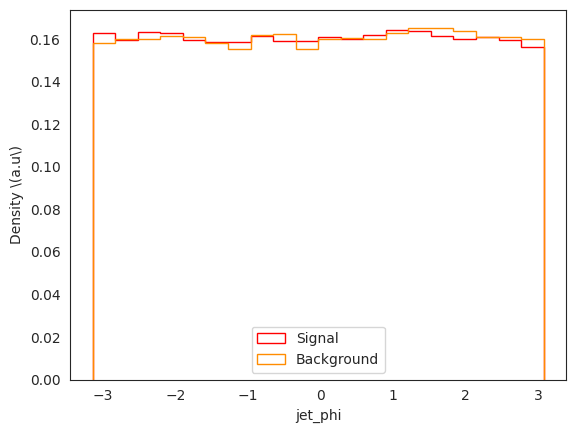

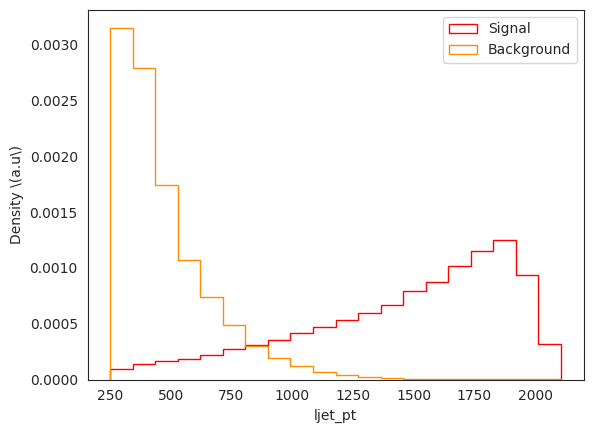

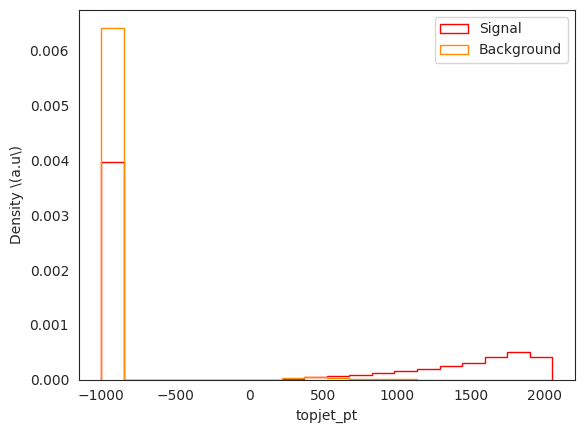

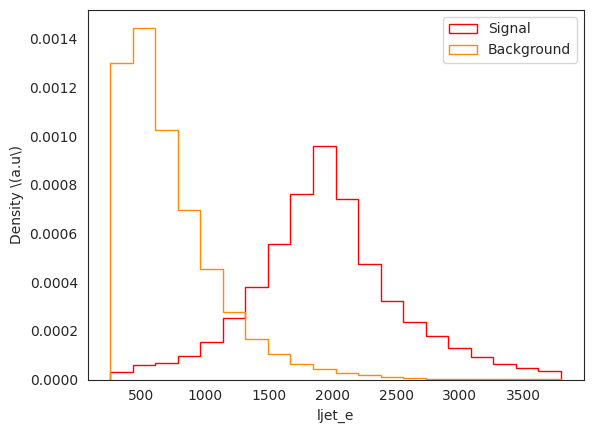

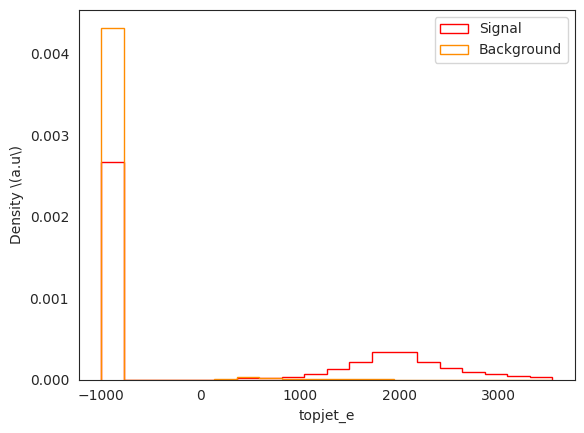

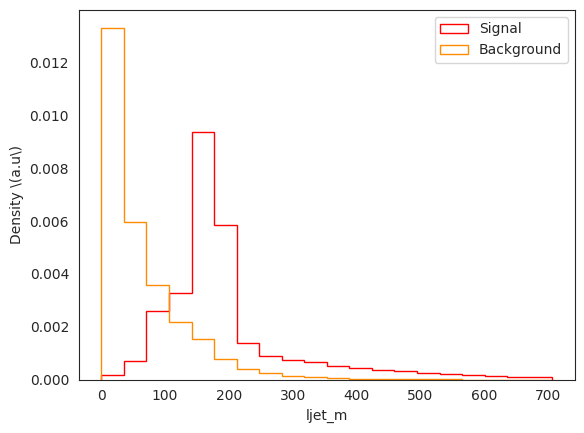

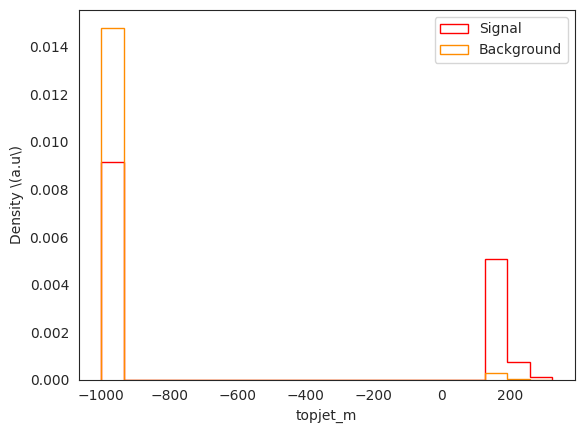

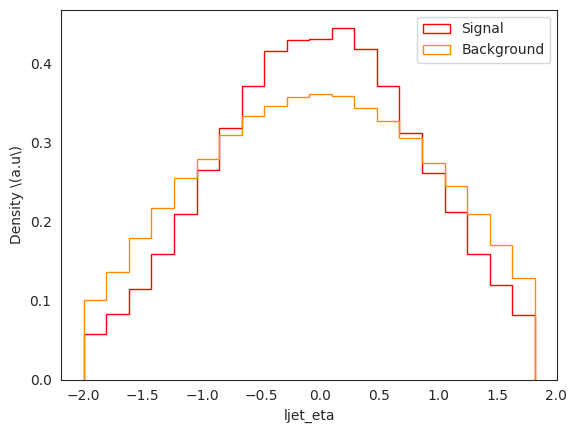

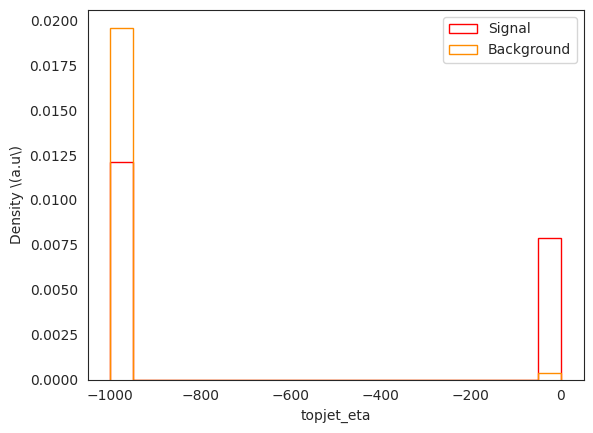

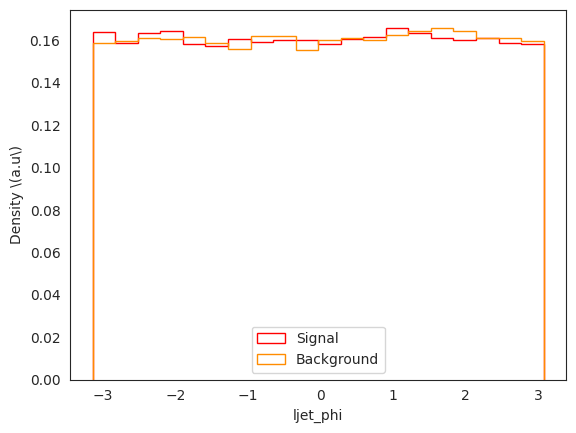

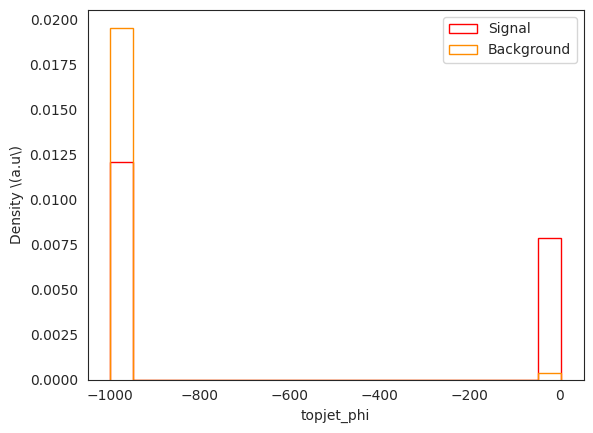

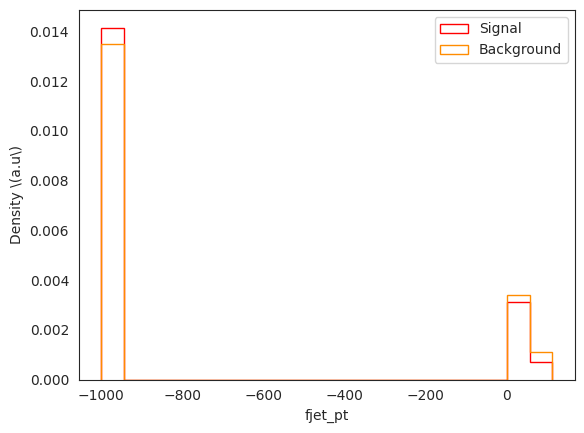

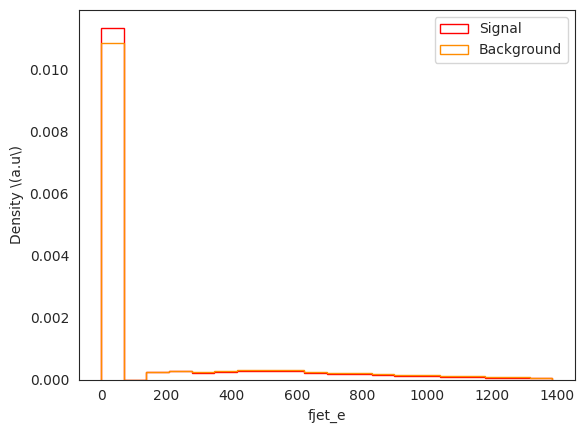

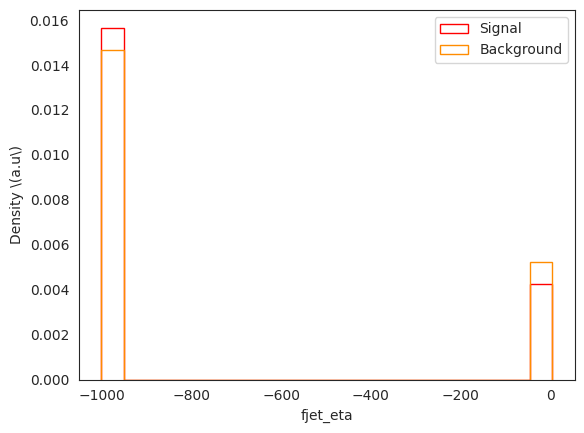

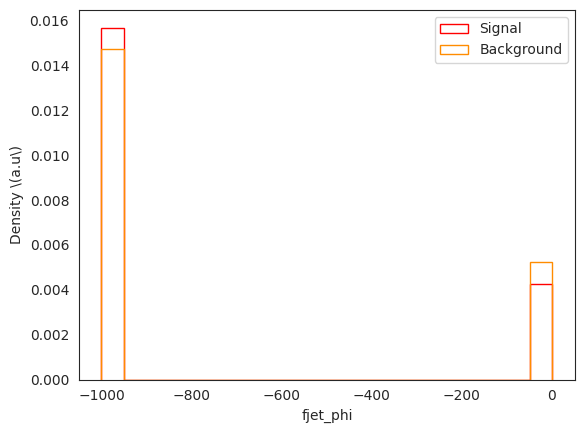

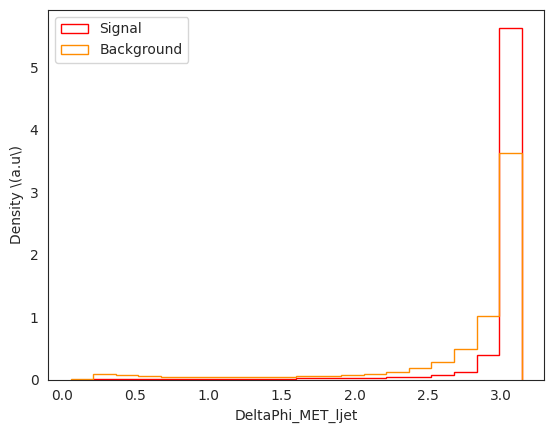

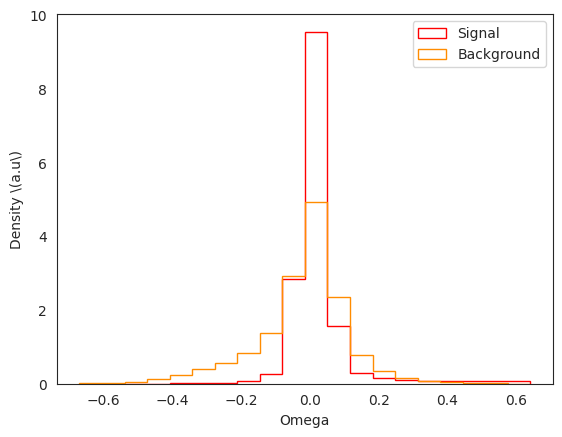

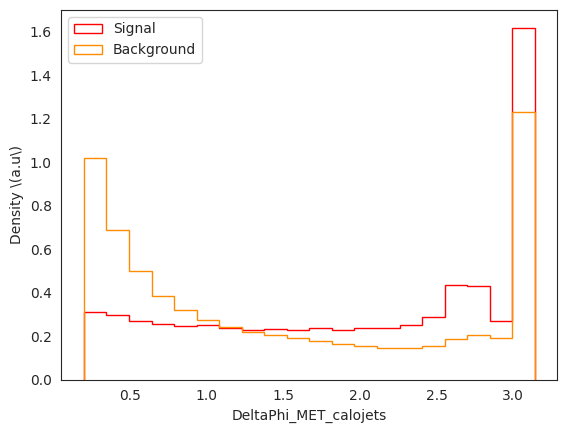

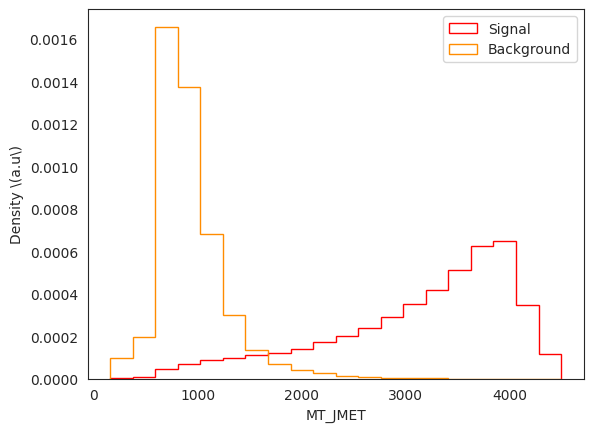

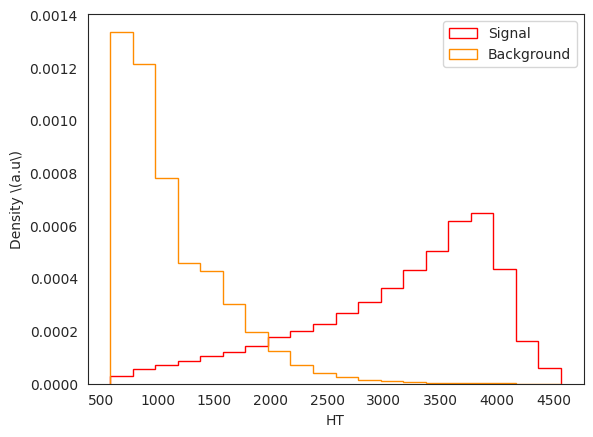

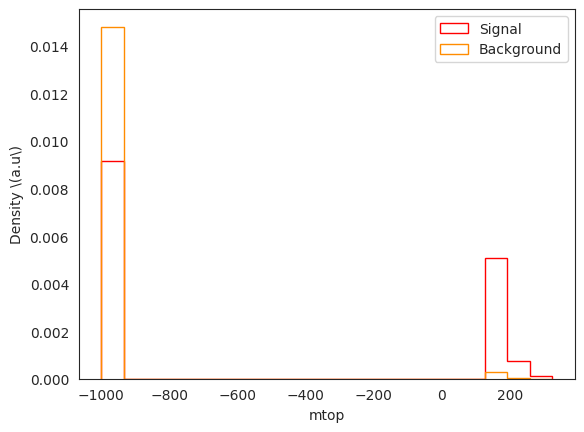

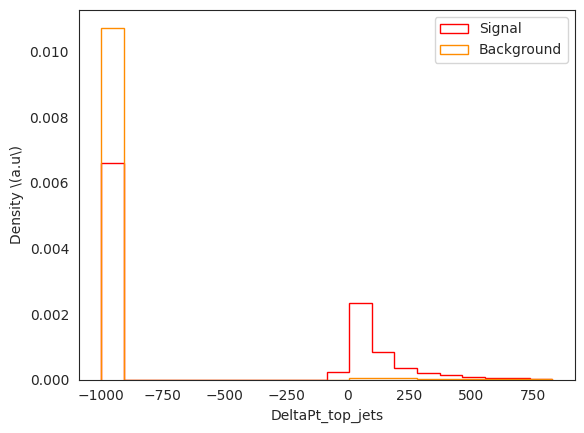

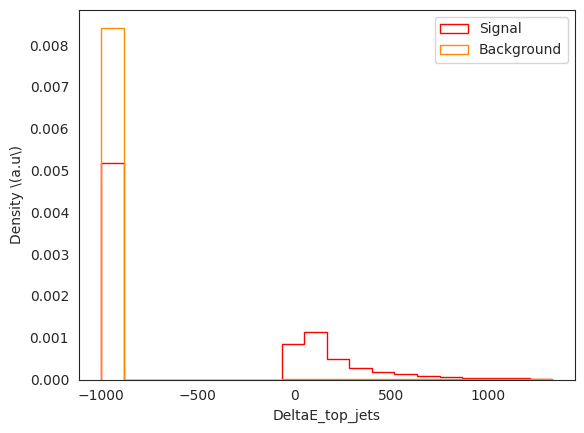

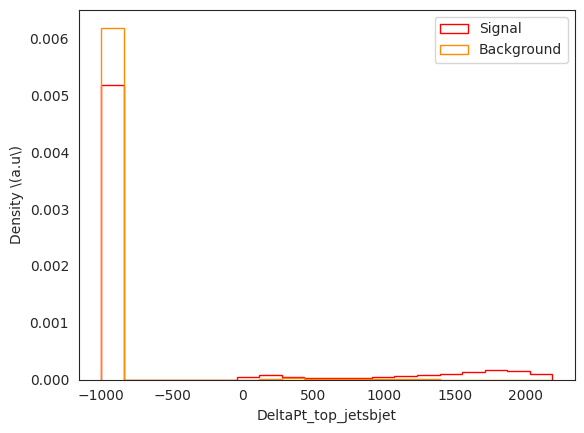

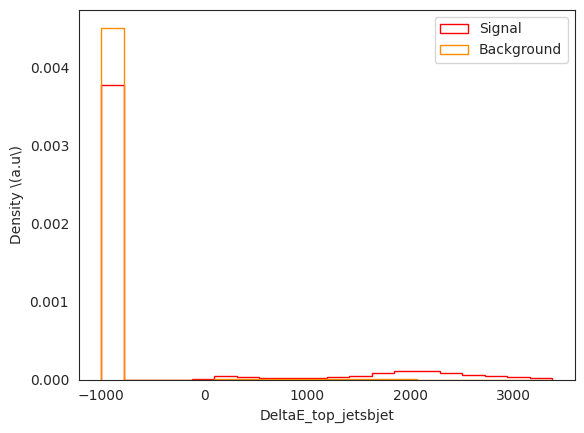

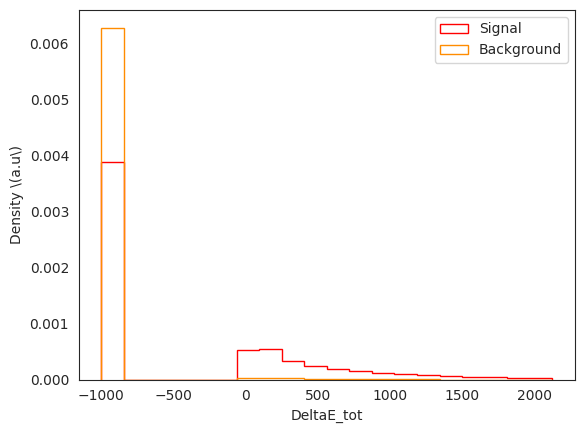

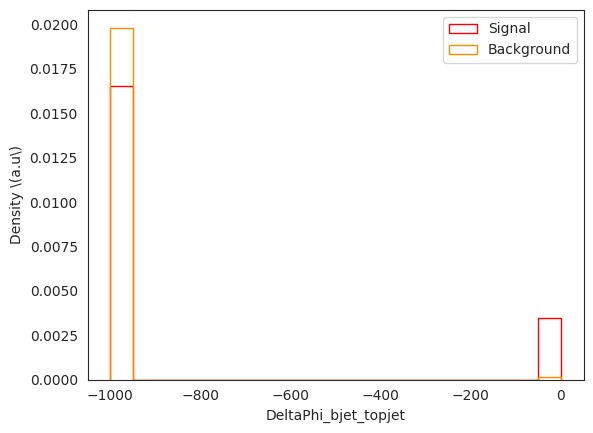

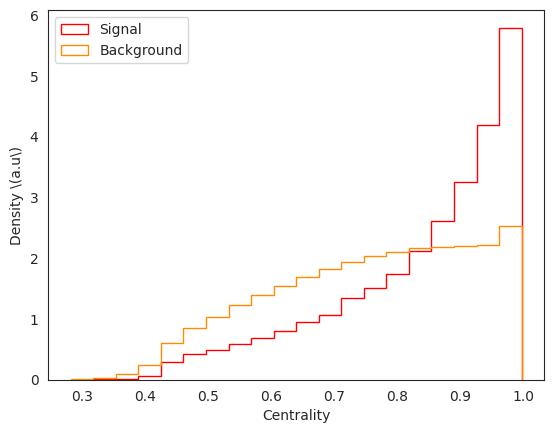

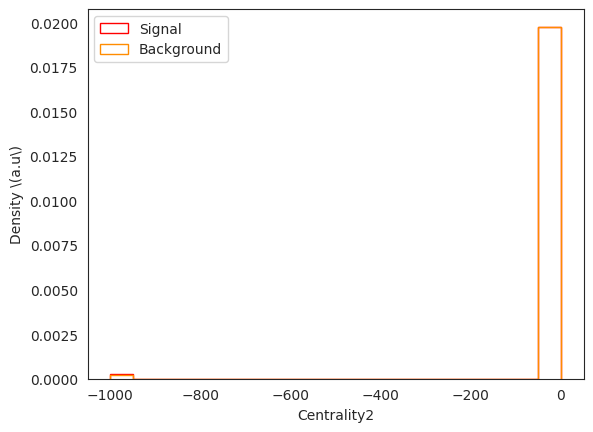

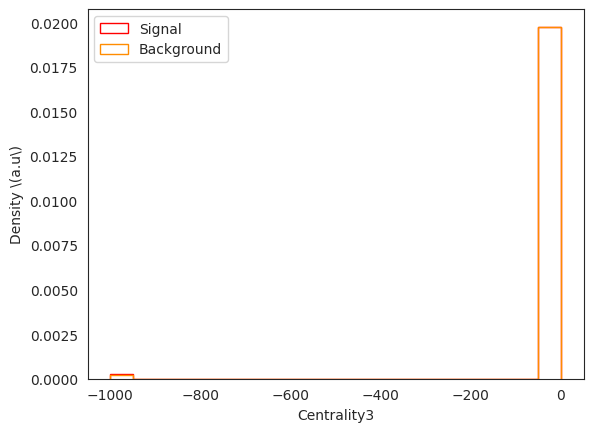

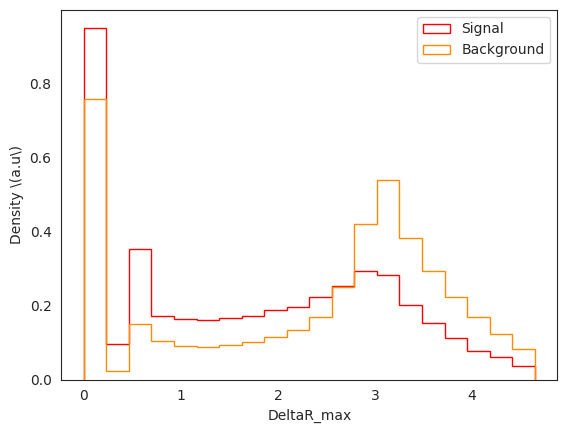

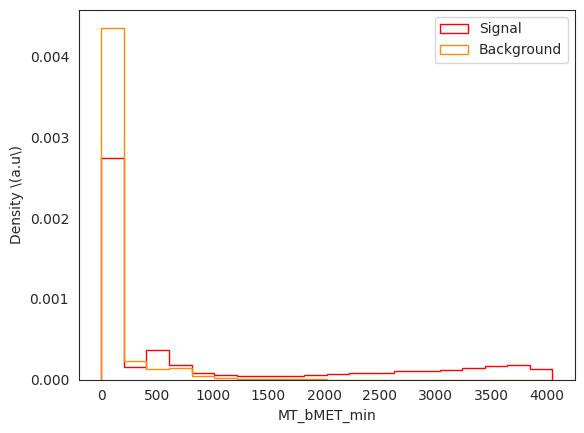

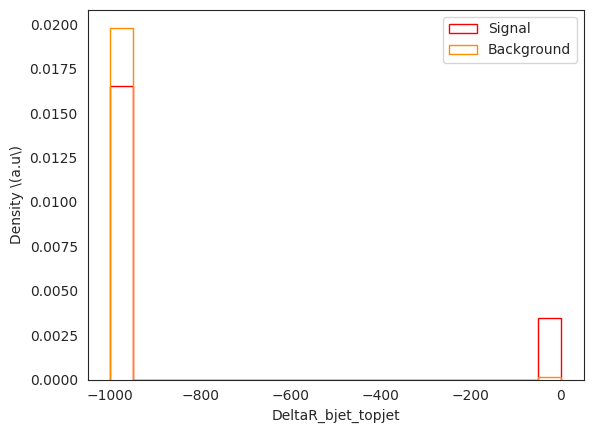

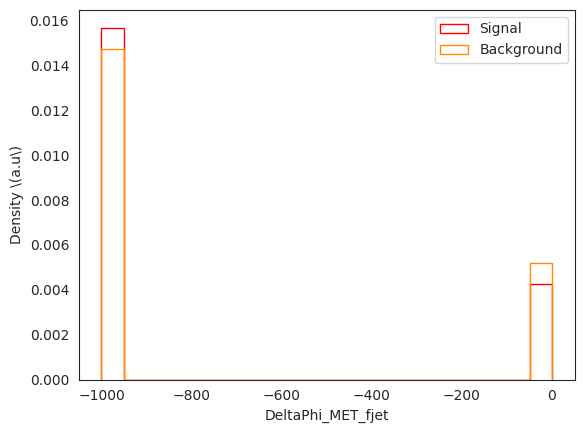

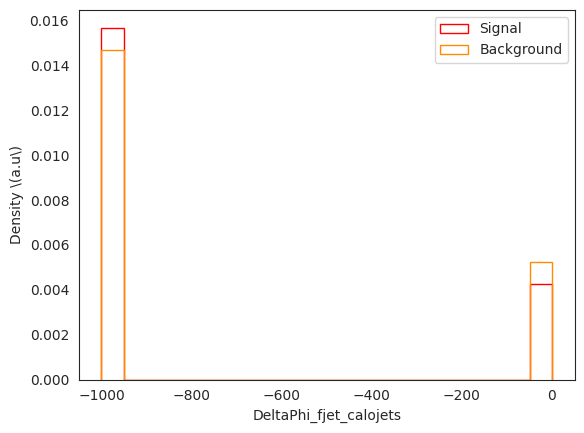

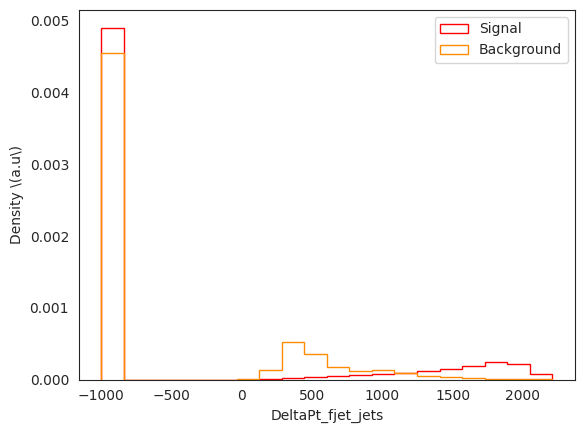

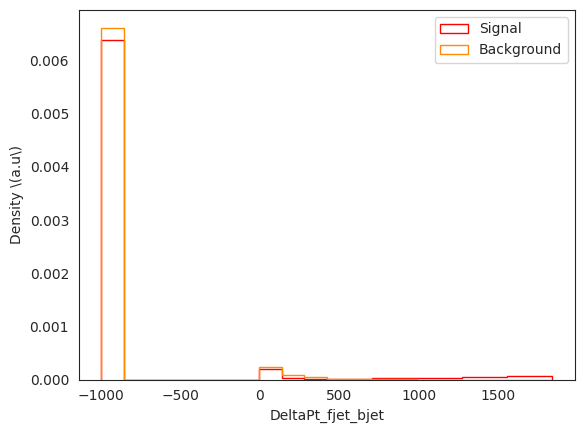

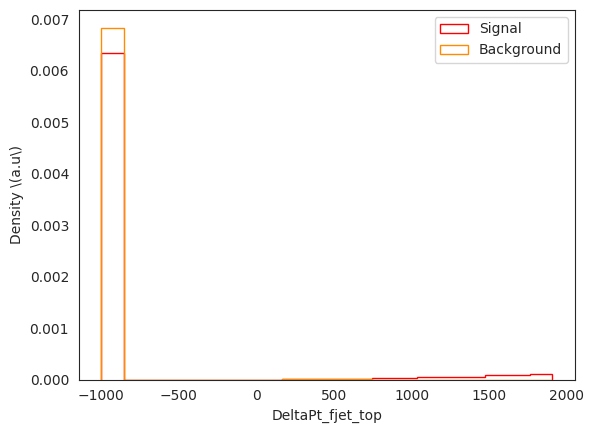

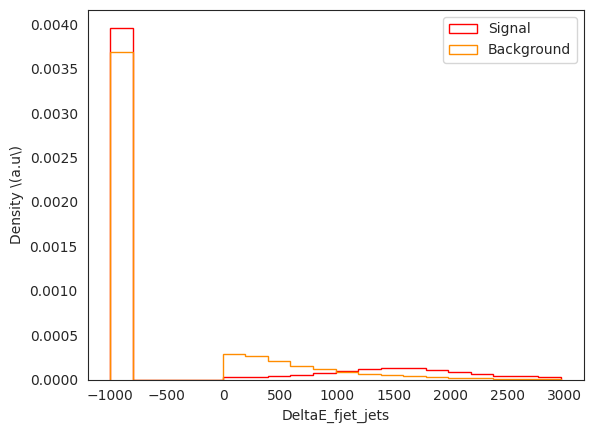

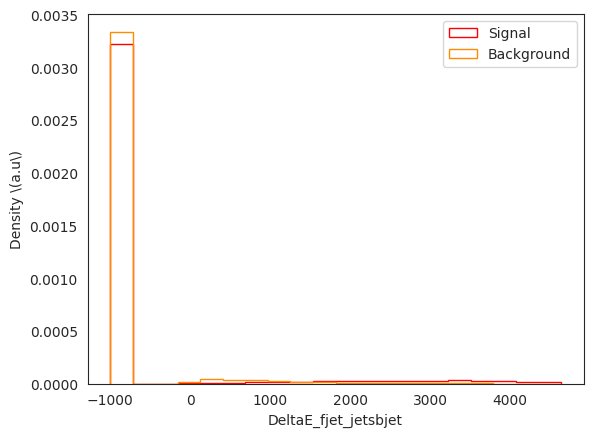

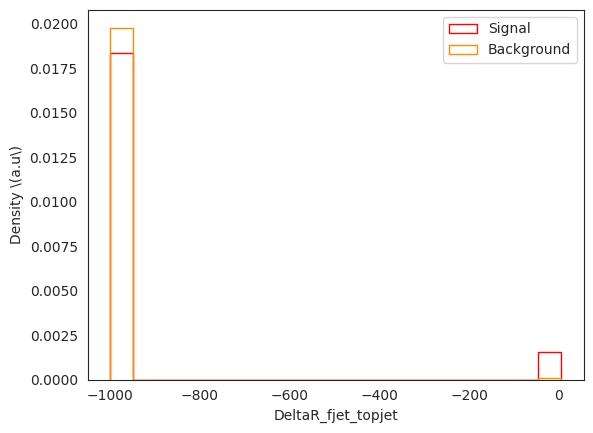

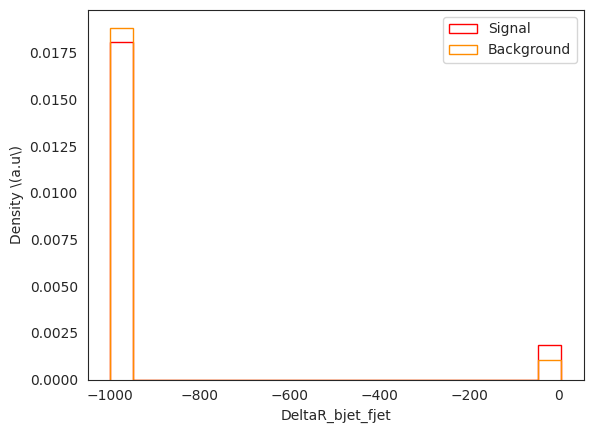

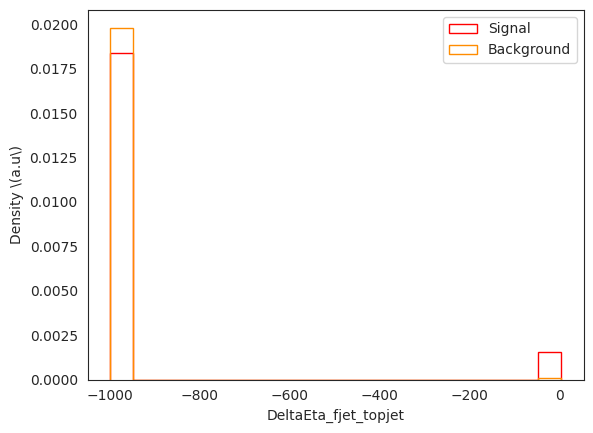

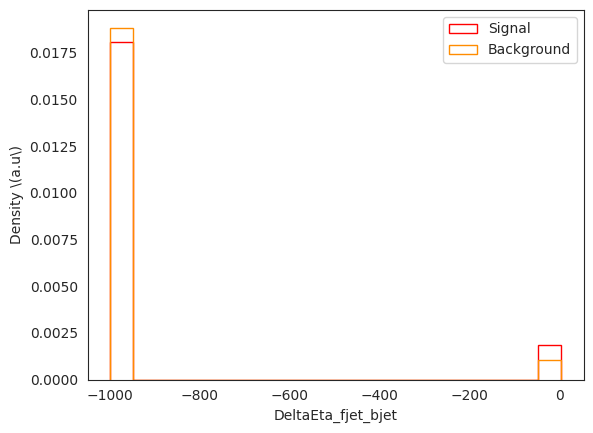

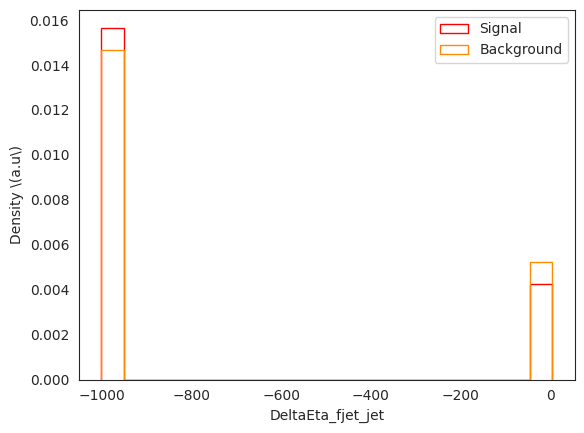

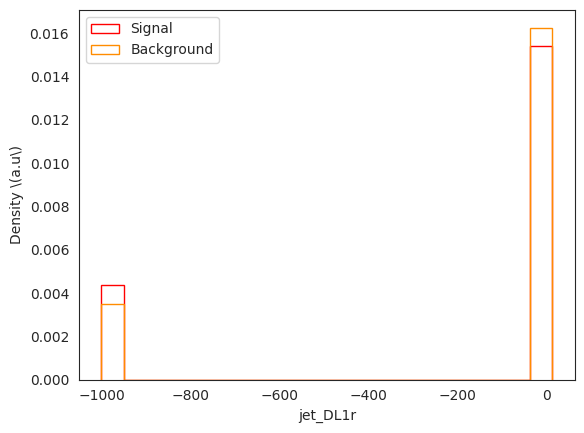

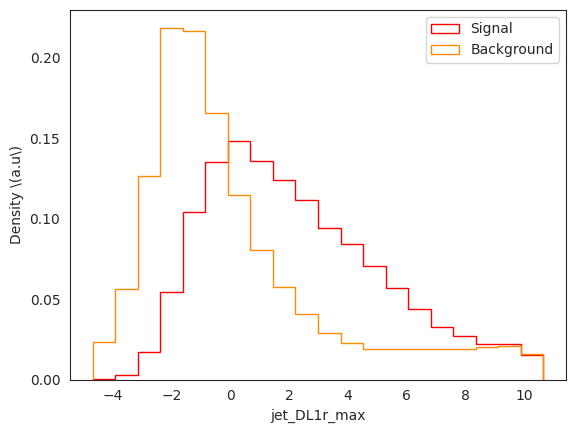

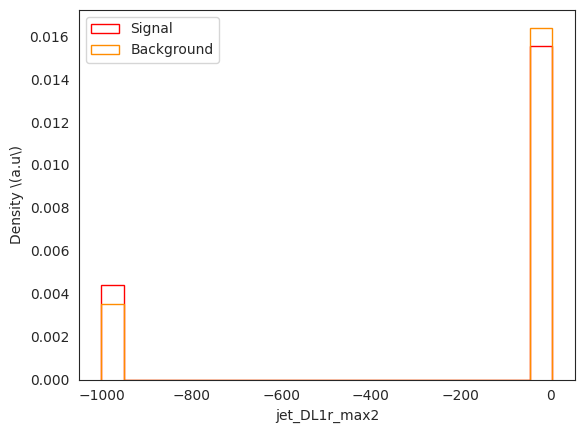

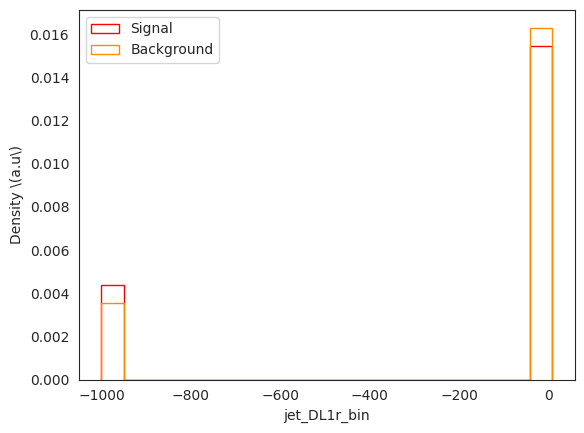

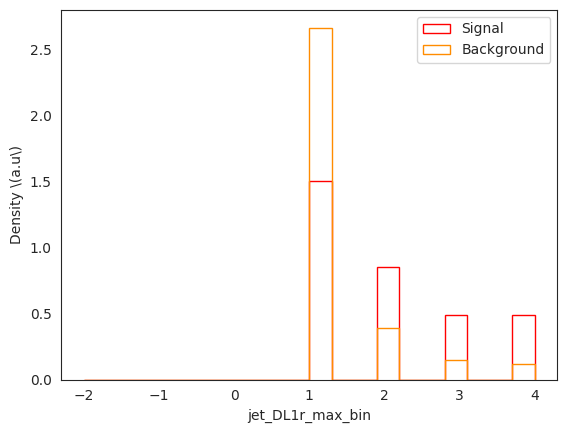

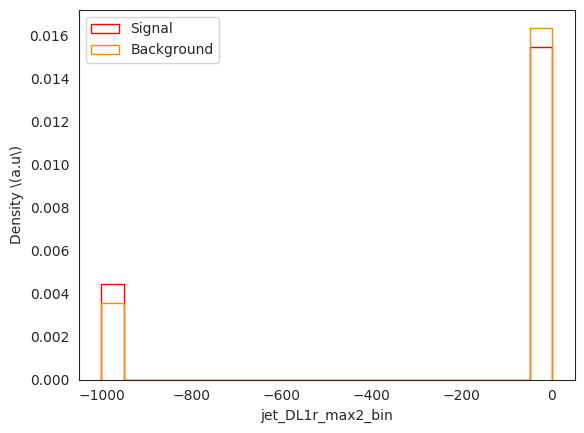

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


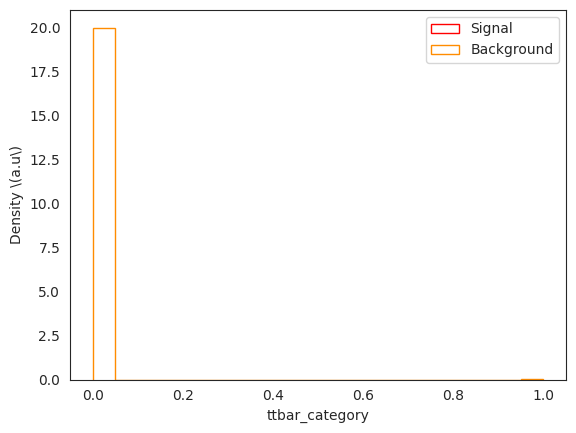

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


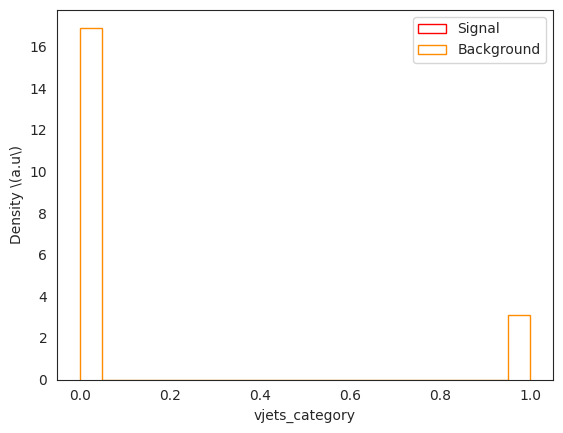

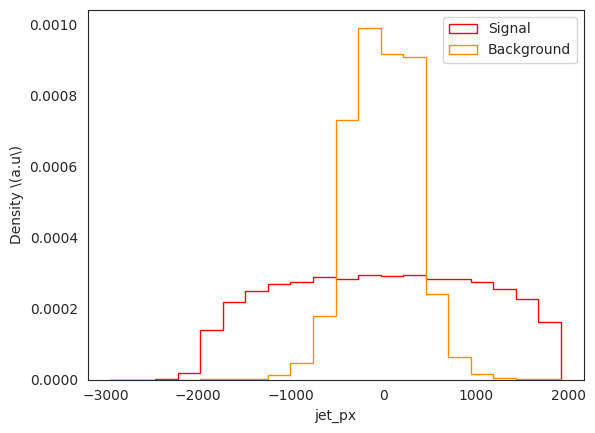

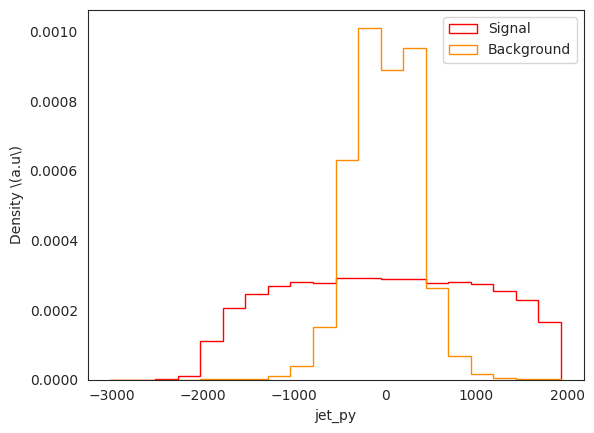

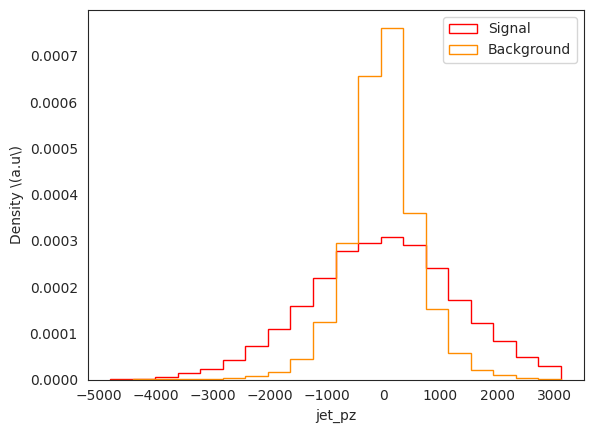

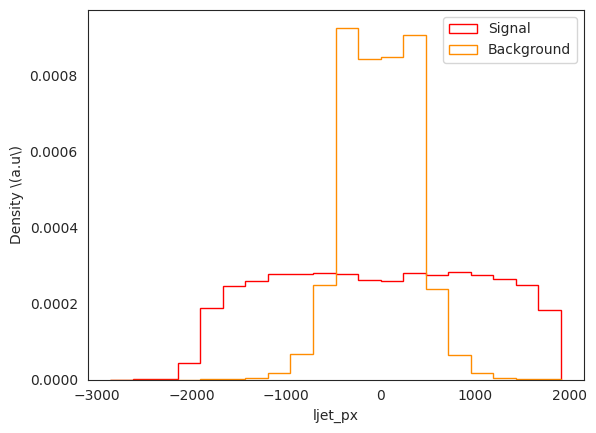

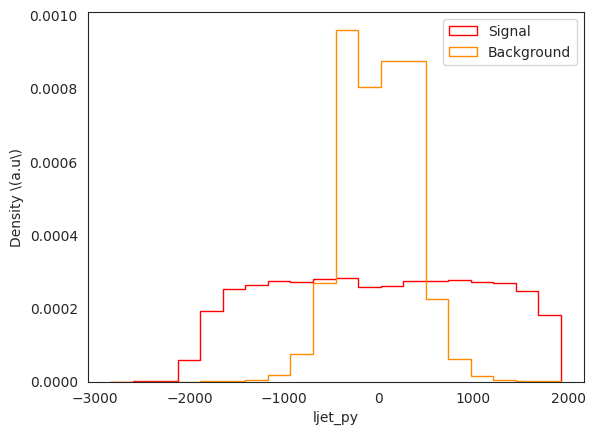

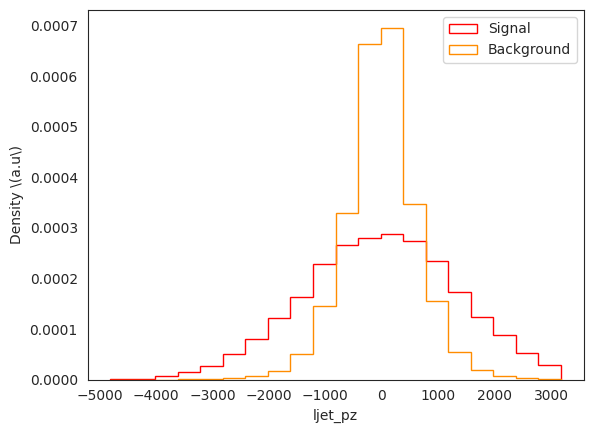

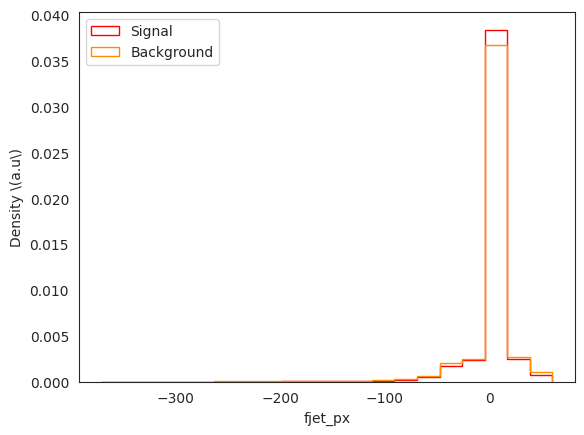

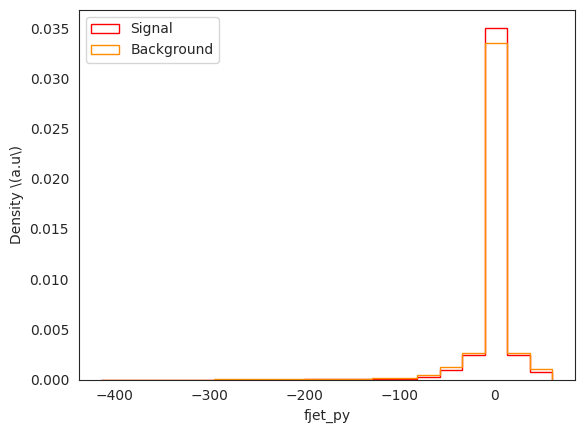

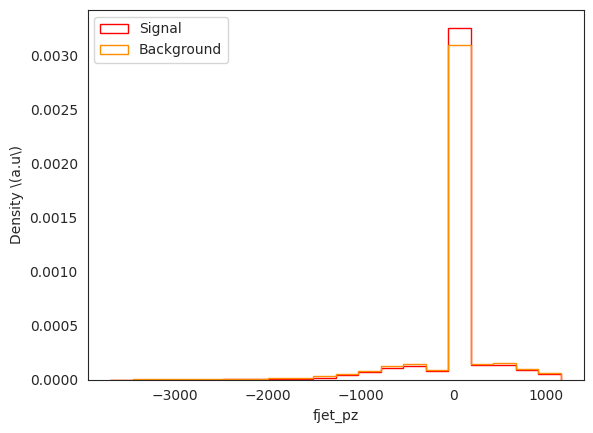

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


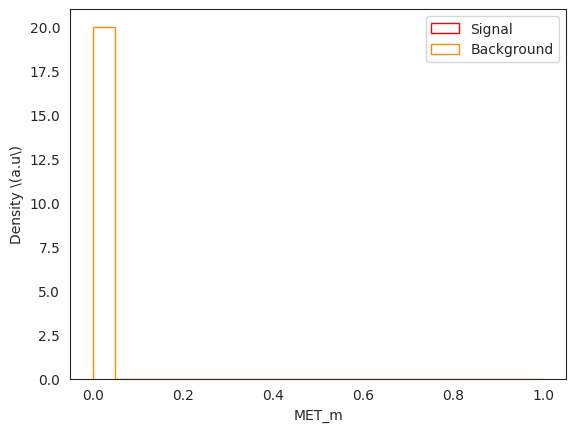

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


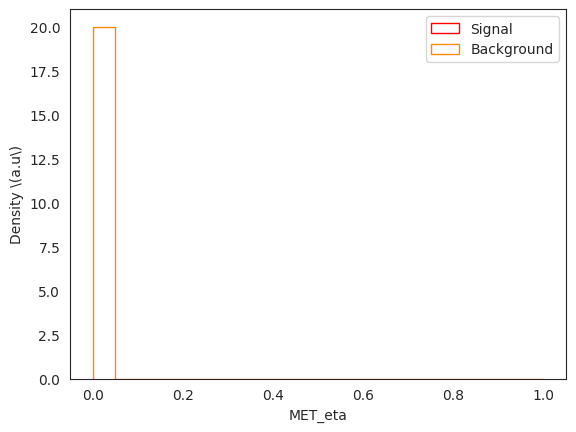

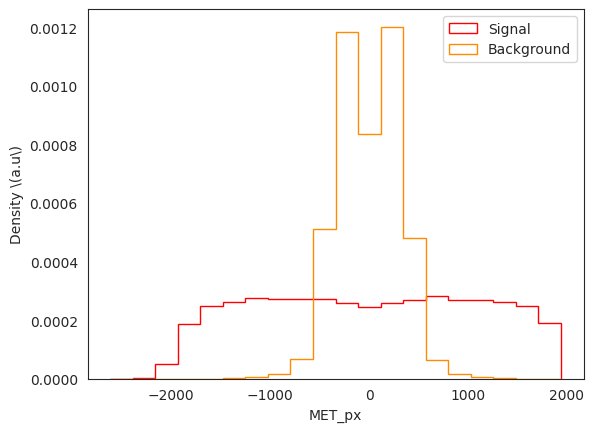

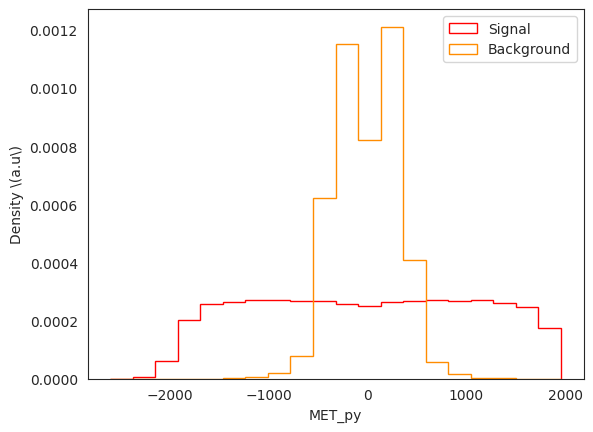

In [ ]:
plot_features = ['MET', 'MET_Phi', 'isOdd', 'isBlind', 'nGoodJets',
       'nGoodbJets', 'nGoodlJets', 'nGoodtoplJets', 'nForwardJets',
       'nTruthJets', 'jet_pt', 'jet_e', 'jet_eta', 'jet_phi', 'ljet_pt',
       'topjet_pt', 'ljet_e', 'topjet_e', 'ljet_m', 'topjet_m', 'ljet_eta',
       'topjet_eta', 'ljet_phi', 'topjet_phi', 'fjet_pt', 'fjet_e', 'fjet_eta',
       'fjet_phi', 'DeltaPhi_MET_ljet', 'Omega', 'DeltaPhi_MET_calojets',
       'MT_JMET', 'HT', 'mtop', 'DeltaPt_top_jets', 'DeltaE_top_jets',
       'DeltaPt_top_jetsbjet', 'DeltaE_top_jetsbjet', 'DeltaE_tot',
       'DeltaPhi_bjet_topjet', 'Centrality', 'Centrality2', 'Centrality3',
       'DeltaR_max', 'MT_bMET_min', 'DeltaR_bjet_topjet', 'DeltaPhi_MET_fjet',
       'DeltaPhi_fjet_calojets', 'DeltaPt_fjet_jets', 'DeltaPt_fjet_bjet',
       'DeltaPt_fjet_top', 'DeltaE_fjet_jets', 'DeltaE_fjet_jetsbjet',
       'DeltaR_fjet_topjet', 'DeltaR_bjet_fjet', 'DeltaEta_fjet_topjet',
       'DeltaEta_fjet_bjet', 'DeltaEta_fjet_jet', 'jet_DL1r', 'jet_DL1r_max',
       'jet_DL1r_max2', 'jet_DL1r_bin', 'jet_DL1r_max_bin',
       'jet_DL1r_max2_bin', 'ttbar_category', 'vjets_category','jet_px', 'jet_py', 'jet_pz', 'ljet_px',
       'ljet_py', 'ljet_pz', 'fjet_px', 'fjet_py', 'fjet_pz', 'MET_m',
       'MET_eta', 'MET_px', 'MET_py']
for feat in plot_features:

    #(We are filtering data signal out of the 99% quantile to get the bulk of the distribution and obtain decent axes limits...)

    bins = plt.hist(Signal.query(f'{feat} < {feat}.quantile(.99)')[feat].values, bins=20, density=True, histtype='step', color='red', label='Signal')
    plt.hist(Background[feat].values, bins=bins[1], density=True, histtype='step', color='darkorange', label='Background')

    plt.xlabel(feat)
    plt.ylabel('Density \(a.u\)')
    plt.legend()
    #plt.yscale("log")
    plt.show()

# Pre-processing data

Computing train_weights so S:B = 1 (important to the DNN , we dont want the small amount of signal events to be ignored)

In [ ]:
sum_w_sig_train = data.query("label==0 & gen_split=='train'")['train_weight'].sum()
sum_w_bkg_train = data.query("label==1 & gen_split=='train'")['train_weight'].sum()
sum_w_sig_val = data.query("label==0 & gen_split=='val'")['train_weight'].sum()
sum_w_bkg_val = data.query("label==1 & gen_split=='val'")['train_weight'].sum()
sum_w_sig_test = data.query("label==0 & gen_split=='test'")['train_weight'].sum()
sum_w_bkg_test = data.query("label==1 & gen_split=='test'")['train_weight'].sum()
sum_w_sig_total = data.query("label==0")['train_weight'].sum()
sum_w_bkg_total = data.query("label==1")['train_weight'].sum()
print(f'1: Sum of weights for training Signal [train] {sum_w_sig_train} and Background [train] {sum_w_bkg_train}')
print(f'1: Sum of weights for training Signal [val] {sum_w_sig_val} and Background [val] {sum_w_bkg_val}')
print(f'1: Sum of weights for training Signal [test] {sum_w_sig_test} and Background [test] {sum_w_bkg_test}')
print(f'1: Sum of weights for training Signal [total] {sum_w_sig_total} and Background [total] {sum_w_bkg_total}')

data['train_weight_2'] = 1

data.loc[data.query('label==1').index,'train_weight_2'] = 3 * data.loc[data.query('label==1').index,'normalisedCombinedWeight'] \
                                                      / data.loc[data.query('label==1').index,'normalisedCombinedWeight'].sum()
data.loc[data.query('label==0').index,'train_weight_2'] = 3 * data.loc[data.query('label==0').index,'normalisedCombinedWeight'] \
                                                      / data.loc[data.query('label==0').index,'normalisedCombinedWeight'].sum()
print('\n')
sum_w_sig_train_2 = data.query("label==0 & gen_split=='train'")['train_weight_2'].sum()
sum_w_bkg_train_2 = data.query("label==1 & gen_split=='train'")['train_weight_2'].sum()
sum_w_sig_val_2 = data.query("label==0 & gen_split=='val'")['train_weight_2'].sum()
sum_w_bkg_val_2 = data.query("label==1 & gen_split=='val'")['train_weight_2'].sum()
sum_w_sig_test_2 = data.query("label==0 & gen_split=='test'")['train_weight_2'].sum()
sum_w_bkg_test_2 = data.query("label==1 & gen_split=='test'")['train_weight_2'].sum()
sum_w_sig_total_2 = data.query("label==0")['train_weight_2'].sum()
sum_w_bkg_total_2 = data.query("label==1")['train_weight_2'].sum()
print(f'2: Sum of weights for training Signal [train] {sum_w_sig_train_2} and Background [train] {sum_w_bkg_train_2}')
print(f'2: Sum of weights for training Signal [val] {sum_w_sig_val_2} and Background [val] {sum_w_bkg_val_2}')
print(f'2: Sum of weights for training Signal [test] {sum_w_sig_test_2} and Background [test] {sum_w_bkg_test_2}')
print(f'2: Sum of weights for training Signal [total] {sum_w_sig_total_2} and Background [total] {sum_w_bkg_total_2}')

1: Sum of weights for training Signal [train] 0.1452311973250272 and Background [train] 1.0
1: Sum of weights for training Signal [val] 0.14477257544853295 and Background [val] 1.0
1: Sum of weights for training Signal [test] 0.1457145218597131 and Background [test] 1.0
1: Sum of weights for training Signal [total] 0.4357182946332729 and Background [total] 3.0


2: Sum of weights for training Signal [train] 0.9937739169482454 and Background [train] 1.0001075601841216
2: Sum of weights for training Signal [val] 1.010362174370207 and Background [val] 1.0024613537541385
2: Sum of weights for training Signal [test] 0.9958639086815465 and Background [test] 0.9974310860617397
2: Sum of weights for training Signal [total] 2.9999999999999987 and Background [total] 2.9999999999999996


Defining training features

In [ ]:
train_features = ['MET', 'MET_Phi', 'isOdd', 'isBlind', 'nGoodJets',
       'nGoodbJets', 'nGoodlJets', 'nGoodtoplJets', 'nForwardJets',
       'nTruthJets', 'jet_pt', 'jet_e', 'jet_eta', 'jet_phi', 'ljet_pt',
       'topjet_pt', 'ljet_e', 'topjet_e', 'ljet_m', 'topjet_m', 'ljet_eta',
       'topjet_eta', 'ljet_phi', 'topjet_phi', 'fjet_pt', 'fjet_e', 'fjet_eta',
       'fjet_phi', 'DeltaPhi_MET_ljet', 'Omega', 'DeltaPhi_MET_calojets',
       'MT_JMET', 'HT', 'mtop', 'DeltaPt_top_jets', 'DeltaE_top_jets',
       'DeltaPt_top_jetsbjet', 'DeltaE_top_jetsbjet', 'DeltaE_tot',
       'DeltaPhi_bjet_topjet', 'Centrality', 'Centrality2', 'Centrality3',
       'DeltaR_max', 'MT_bMET_min', 'DeltaR_bjet_topjet', 'DeltaPhi_MET_fjet',
       'DeltaPhi_fjet_calojets', 'DeltaPt_fjet_jets', 'DeltaPt_fjet_bjet',
       'DeltaPt_fjet_top', 'DeltaE_fjet_jets', 'DeltaE_fjet_jetsbjet',
       'DeltaR_fjet_topjet', 'DeltaR_bjet_fjet', 'DeltaEta_fjet_topjet',
       'DeltaEta_fjet_bjet', 'DeltaEta_fjet_jet', 'jet_DL1r', 'jet_DL1r_max',
       'jet_DL1r_max2', 'jet_DL1r_bin', 'jet_DL1r_max_bin',
       'jet_DL1r_max2_bin', 'ttbar_category', 'vjets_category','jet_px', 'jet_py', 'jet_pz', 'ljet_px',
       'ljet_py', 'ljet_pz', 'fjet_px', 'fjet_py', 'fjet_pz', 'MET_m',
       'MET_eta', 'MET_px', 'MET_py']
print(len(train_features))

79


Split data into train:validation:test sets

In [ ]:

x_train = data[data['gen_split'] == 'train']
y_train = data[data['gen_split'] == 'train']
w_train = data[data['gen_split'] == 'train']

x_train = x_train[train_features]
y_train = y_train['label']
w_train = w_train['train_weight_2']

x_val = data[data['gen_split'] == 'val']
y_val = data[data['gen_split'] == 'val']
w_val = data[data['gen_split'] == 'val']

x_val = x_val[train_features]
y_val = y_val['label']
w_val = w_val['train_weight_2']

x_test = data[data['gen_split'] == 'test']
y_test = data[data['gen_split'] == 'test']
w_test = data[data['gen_split'] == 'test']

x_test = x_test[train_features]
y_test = y_test['label']
w_test = w_test['train_weight_2']

print(f' Train sample x {len(x_train)} events (y {len(y_train)} events) (w {len(w_train)} events)')
print(f' Val   sample x {len(x_val)} events (y {len(y_val)} events) (w {len(w_val)} events)')
print(f' Test  sample x {len(x_test)} events (y {len(y_test)} events) (w {len(w_test)} events)')


 Train sample x 525010 events (y 525010 events) (w 525010 events)
 Val   sample x 523878 events (y 523878 events) (w 523878 events)
 Test  sample x 524171 events (y 524171 events) (w 524171 events)


Visualizing the effect of STD and PCA

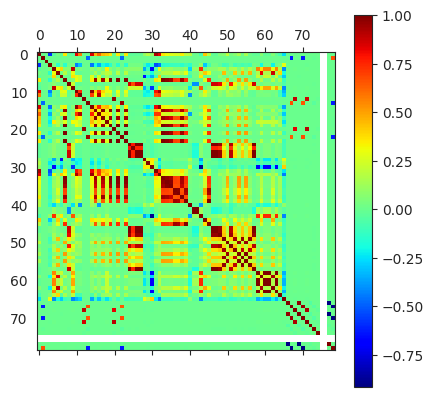

In [ ]:
x_before = pd.concat([x_train,x_test,x_val],ignore_index=True)
x_before.corr()
fig = plt.matshow(x_before.corr(), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

<ipython-input-13-745455a89929>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, hist_kws={"range": [0, 3500]}, norm_hist = True, kde=False, label = "before standard scaler")#, fit=stats.gamma);


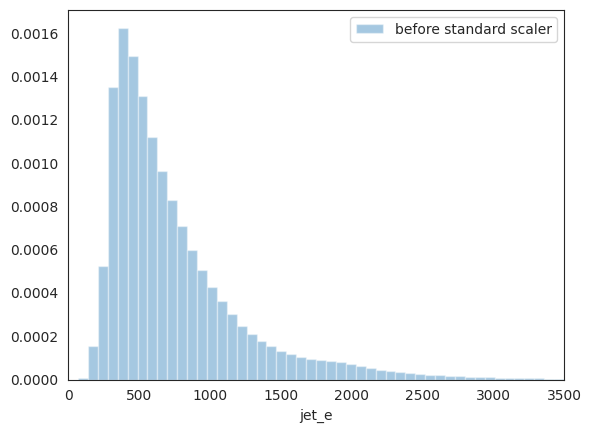

In [ ]:
x = x_before["jet_e"]
ax = sns.distplot(x, hist_kws={"range": [0, 3500]}, norm_hist = True, kde=False, label = "before standard scaler")#, fit=stats.gamma);
ax.set_xlim(0, 3500)
plt.legend()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()
x_train_std = scaler.fit_transform(x_train)
x_val_std   = scaler.transform(x_val)
x_test_std  = scaler.transform(x_test)
x_train_std_pca = pca.fit_transform(x_train_std)
x_val_std_pca   = pca.transform(x_val_std)
x_test_std_pca  = pca.transform(x_test_std)

In [ ]:
x_train_std_pca_df = pd.DataFrame(x_train_std_pca, columns=train_features)
x_val_std_pca_df = pd.DataFrame(x_val_std_pca, columns=train_features)
x_test_std_pca_df = pd.DataFrame(x_test_std_pca, columns=train_features)

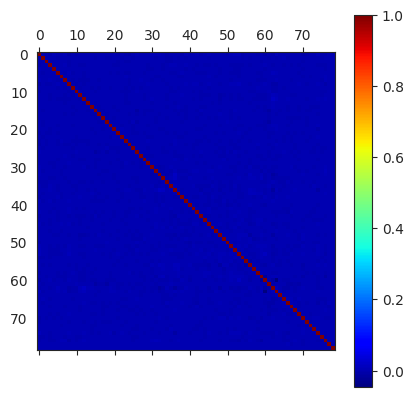

In [ ]:
x_after = pd.concat([x_train_std_pca_df ,x_test_std_pca_df,x_val_std_pca_df],ignore_index=True)
x_after.corr()
fig = plt.matshow(x_after.corr(), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

<ipython-input-17-fdd21ff4bfea>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, hist_kws={"range": [-10, 10]}, norm_hist = True, kde=False, label = "after standard scaler")#, fit=stats.gamma);


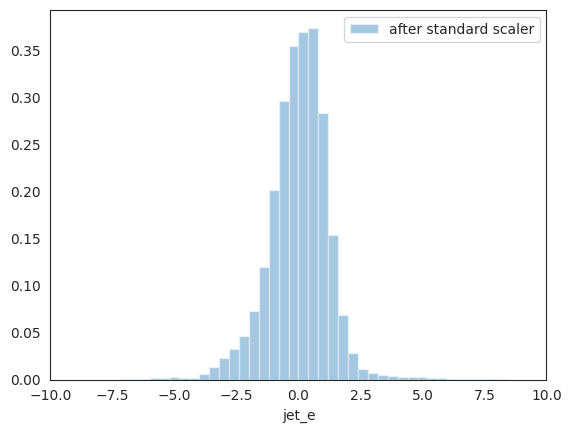

In [ ]:
x = x_after["jet_e"]
ax = sns.distplot(x, hist_kws={"range": [-10, 10]}, norm_hist = True, kde=False, label = "after standard scaler")#, fit=stats.gamma);
ax.set_xlim(-10, 10)
plt.legend()

# Supervised method DNN

Creating the DNN model

In [ ]:
model = Sequential()

# The Input Layer: batch normalisation
model.add(Dense(79, kernel_initializer='normal',input_dim  = x_train.shape[1], activation='relu'))

# The Hidden Layers
model.add(Dense(70, kernel_initializer='normal',activation='relu'))
model.add(Dense(30, kernel_initializer='normal',activation='relu'))

# The Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='sigmoid'))

# Compile the network
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 79)                6320      
                                                                 
 dense_1 (Dense)             (None, 70)                5600      
                                                                 
 dense_2 (Dense)             (None, 30)                2130      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train_std_pca, y_train, sample_weight=w_train, validation_data=(x_val_std_pca,y_val,w_val),
                       epochs=20, batch_size=1024, callbacks=EarlyStopping(patience=2))

Epoch 1/20
512/513 [============================>.] - ETA: 0s - loss: 2.6217e-06 - accuracy: 0.1619

513/513 [==============================] - 112s 217ms/step - loss: 2.6219e-06 - accuracy: 0.1618 - val_loss: 2.6433e-06 - val_accuracy: 0.0858
Epoch 2/20
502/513 [============================>.] - ETA: 0s - loss: 2.5913e-06 - accuracy: 0.0742

513/513 [==============================] - 3s 5ms/step - loss: 2.5902e-06 - accuracy: 0.0748 - val_loss: 2.5860e-06 - val_accuracy: 0.1032
Epoch 3/20
502/513 [============================>.] - ETA: 0s - loss: 2.4567e-06 - accuracy: 0.1947

513/513 [==============================] - 3s 6ms/step - loss: 2.4548e-06 - accuracy: 0.1980 - val_loss: 2.3195e-06 - val_accuracy: 0.3496
Epoch 4/20
510/513 [============================>.] - ETA: 0s - loss: 2.0126e-06 - accuracy: 0.5082

513/513 [==============================] - 4s 7ms/step - loss: 2.0117e-06 - accuracy: 0.5090 - val_loss: 1.7819e-06 - val_accuracy: 0.6551
Epoch 5/20
503/513 [============================>.] - ETA: 0s - loss: 1.6054e-06 - accuracy: 0.7321

513/513 [==============================] - 3s 6ms/step - loss: 1.6035e-06 - accuracy: 0.7333 - val_loss: 1.5137e-06 - val_accuracy: 0.7879
Epoch 6/20
506/513 [============================>.] - ETA: 0s - loss: 1.4174e-06 - accuracy: 0.8118

513/513 [==============================] - 3s 6ms/step - loss: 1.4167e-06 - accuracy: 0.8121 - val_loss: 1.3713e-06 - val_accuracy: 0.8304
Epoch 7/20
506/513 [============================>.] - ETA: 0s - loss: 1.2960e-06 - accuracy: 0.8421

513/513 [==============================] - 3s 6ms/step - loss: 1.2953e-06 - accuracy: 0.8422 - val_loss: 1.2605e-06 - val_accuracy: 0.8525
Epoch 8/20
505/513 [============================>.] - ETA: 0s - loss: 1.1939e-06 - accuracy: 0.8635

513/513 [==============================] - 4s 7ms/step - loss: 1.1925e-06 - accuracy: 0.8638 - val_loss: 1.1584e-06 - val_accuracy: 0.8755
Epoch 9/20
503/513 [============================>.] - ETA: 0s - loss: 1.0900e-06 - accuracy: 0.8861

513/513 [==============================] - 3s 5ms/step - loss: 1.0898e-06 - accuracy: 0.8863 - val_loss: 1.0475e-06 - val_accuracy: 0.8959
Epoch 10/20
502/513 [============================>.] - ETA: 0s - loss: 9.7232e-07 - accuracy: 0.9040

513/513 [==============================] - 3s 6ms/step - loss: 9.7116e-07 - accuracy: 0.9042 - val_loss: 9.1347e-07 - val_accuracy: 0.9137
Epoch 11/20
511/513 [============================>.] - ETA: 0s - loss: 8.2834e-07 - accuracy: 0.9204

513/513 [==============================] - 3s 6ms/step - loss: 8.2791e-07 - accuracy: 0.9205 - val_loss: 7.5438e-07 - val_accuracy: 0.9277
Epoch 12/20
506/513 [============================>.] - ETA: 0s - loss: 6.6937e-07 - accuracy: 0.9326

513/513 [==============================] - 3s 7ms/step - loss: 6.6843e-07 - accuracy: 0.9327 - val_loss: 5.9079e-07 - val_accuracy: 0.9383
Epoch 13/20
504/513 [============================>.] - ETA: 0s - loss: 5.2471e-07 - accuracy: 0.9413

513/513 [==============================] - 3s 6ms/step - loss: 5.2361e-07 - accuracy: 0.9413 - val_loss: 4.6027e-07 - val_accuracy: 0.9444
Epoch 14/20
507/513 [============================>.] - ETA: 0s - loss: 4.2108e-07 - accuracy: 0.9454

513/513 [==============================] - 3s 6ms/step - loss: 4.2085e-07 - accuracy: 0.9454 - val_loss: 3.7717e-07 - val_accuracy: 0.9478
Epoch 15/20
506/513 [============================>.] - ETA: 0s - loss: 3.5883e-07 - accuracy: 0.9479

513/513 [==============================] - 3s 6ms/step - loss: 3.5953e-07 - accuracy: 0.9479 - val_loss: 3.2972e-07 - val_accuracy: 0.9488
Epoch 16/20
511/513 [============================>.] - ETA: 0s - loss: 3.2462e-07 - accuracy: 0.9488

513/513 [==============================] - 3s 7ms/step - loss: 3.2467e-07 - accuracy: 0.9488 - val_loss: 3.0257e-07 - val_accuracy: 0.9492
Epoch 17/20
501/513 [============================>.] - ETA: 0s - loss: 3.0491e-07 - accuracy: 0.9490

513/513 [==============================] - 3s 6ms/step - loss: 3.0417e-07 - accuracy: 0.9491 - val_loss: 2.8608e-07 - val_accuracy: 0.9499
Epoch 18/20
512/513 [============================>.] - ETA: 0s - loss: 2.9145e-07 - accuracy: 0.9498

513/513 [==============================] - 3s 5ms/step - loss: 2.9135e-07 - accuracy: 0.9498 - val_loss: 2.7527e-07 - val_accuracy: 0.9499
Epoch 19/20
510/513 [============================>.] - ETA: 0s - loss: 2.8280e-07 - accuracy: 0.9497

513/513 [==============================] - 3s 6ms/step - loss: 2.8270e-07 - accuracy: 0.9497 - val_loss: 2.6794e-07 - val_accuracy: 0.9505
Epoch 20/20
509/513 [============================>.] - ETA: 0s - loss: 2.7675e-07 - accuracy: 0.9502

513/513 [==============================] - 3s 6ms/step - loss: 2.7655e-07 - accuracy: 0.9502 - val_loss: 2.6260e-07 - val_accuracy: 0.9502


In [ ]:
y_train_pred = model.predict(x_train_std_pca)
y_val_pred = model.predict(x_val_std_pca)

16372/16372 [==============================] - 15s 900us/step


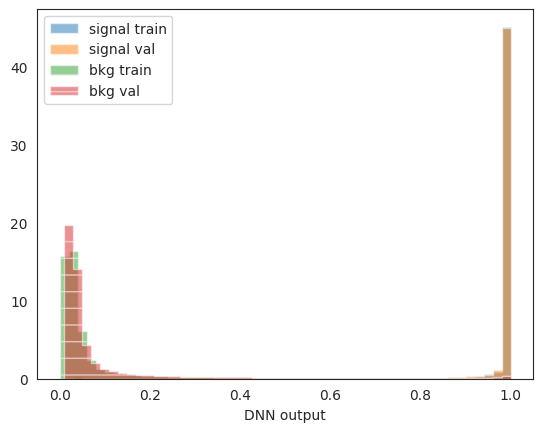

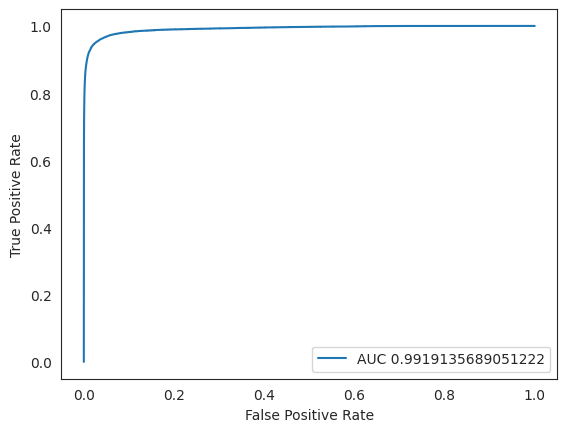

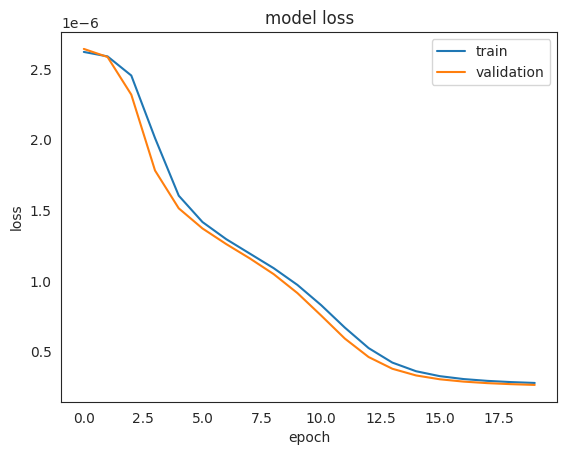

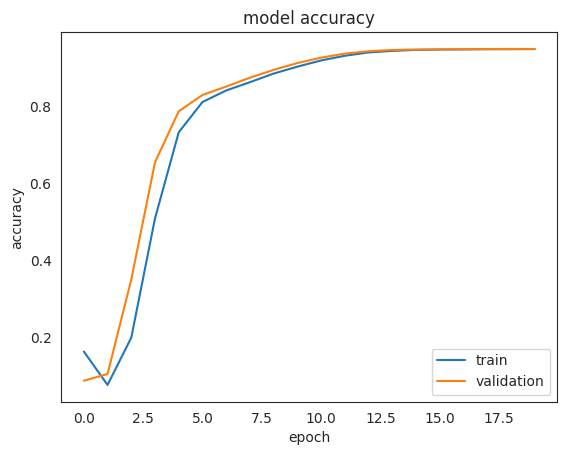

In [ ]:
bins = plt.hist(y_train_pred[np.where(y_train == 1)], bins=50, density=True, histtype='stepfilled', alpha=0.5, label='signal train')
plt.hist(y_val_pred[np.where(y_val == 1)], bins=bins[1], density=True, histtype='stepfilled', alpha=0.5, label='signal val')

plt.hist(y_train_pred[np.where(y_train == 0)], bins=50, density=True, histtype='stepfilled', alpha=0.5, hatch='-', label='bkg train')
plt.hist(y_val_pred[np.where(y_val == 0)], bins=bins[1], density=True, histtype='stepfilled', alpha=0.5, hatch='-', label='bkg val')

plt.xlabel('DNN output')
plt.legend(loc='upper left')
plt.show()

fpr, tpr, _ = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)
plt.plot(fpr,tpr,label=f'AUC {auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

Using test sample and performing exclusion fit

In [ ]:
y_test_pred = model.predict(x_test_std_pca)

16381/16381 [==============================] - 15s 905us/step


In [ ]:
test_weights_df = data[data['gen_split'] == 'test']
test_weights_df_s = test_weights_df[test_weights_df['label'] == 1]
test_weights_s = []
test_weights_s = test_weights_df_s['normalisedCombinedWeight'].values
test_weights_df_b = test_weights_df[test_weights_df['label'] == 0]
test_weights_b = []
test_weights_b = test_weights_df_b['normalisedCombinedWeight'].values
test_weights_t = []
test_weights_t = test_weights_df['normalisedCombinedWeight'].values



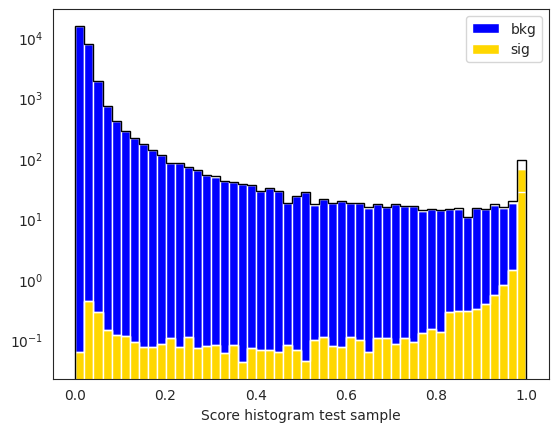

In [ ]:
bins= plt.hist(y_test_pred[np.where(y_test == 0)], bins=50, weights= test_weights_b, histtype='bar', stacked=True, fill=True, color=['blue'],label=['bkg'])
bin_counts_b, bin_edges_b, _ = plt.hist(y_test_pred[np.where(y_test == 0)],bins=bins[1],weights=test_weights_b, histtype='step', color='white')
bin_centres = (bin_edges_b[:-1] + bin_edges_b[1:]) / 2
y_error = np.sqrt(bin_counts_b)
#plt.errorbar(x=bin_centres, y=bin_counts,
#            yerr=y_error, color='black', fmt='o', capsize=2, label='data')



bins = plt.hist(y_test_pred[np.where(y_test == 1)], bins=bins[1], weights= test_weights_s, histtype='bar', stacked=True, fill=True, color=['gold'],label=['sig'])
bin_counts_s, bin_edges_s , _ = plt.hist(y_test_pred[np.where(y_test == 1)],bins=bins[1],weights=test_weights_s, histtype='step', color='white')
bin_centres = (bin_edges_s[:-1] + bin_edges_s[1:]) / 2
y_error = np.sqrt(bin_counts_s)
#plt.errorbar(x=bin_centres, y=bin_counts,
#             yerr=y_error, color='black', fmt='o', capsize=2, label='data')


bin_counts_t, bin_edges_t , _ = plt.hist(y_test_pred,bins=bins[1],weights=test_weights_t, histtype='step', color='black')
bin_centres = (bin_edges_t[:-1] + bin_edges_t[1:]) / 2
y_error = np.sqrt(bin_counts_t)
#plt.errorbar(x=bin_centres, y=bin_counts,
#             yerr=y_error, color='black', fmt='o', capsize=2, label='data')

plt.legend()
plt.xlabel('Score histogram test sample')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

creating a pyhf model for DNN test sample output

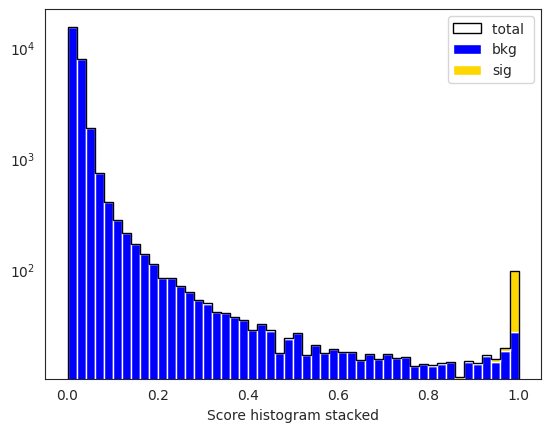

In [ ]:
y_test_pred_bkg = np.squeeze(y_test_pred[np.where(y_test == 0)])
bck = np.histogram(y_test_pred_bkg, bins=50, weights= test_weights_b)
bck_count, bck_edges = np.histogram(y_test_pred_bkg, bins=50, weights= test_weights_b)
bck_centres = (bck_edges[:-1] + bck_edges[1:])/ 2
bck_width = np.diff(bck_edges)[0]
plt.bar(bck_centres,bck_count, label = 'bkg', color = 'blue', width = bck_width)


y_test_pred_sig = np.squeeze(y_test_pred[np.where(y_test == 1)])
sig = np.histogram(y_test_pred_sig, bins=50, weights= test_weights_s)
sig_count, sig_edges = np.histogram(y_test_pred_sig, bins=50, weights= test_weights_s)
plt.bar(bck_centres,sig_count, label = 'sig', color = 'gold', width = bck_width, bottom =bck_count)


y_test_pred_tot = np.squeeze(y_test_pred)
tot = np.histogram(y_test_pred_tot, bins=bck[1], weights= test_weights_t)
tot_edges = tot[1].tolist()

plt.hist(y_test_pred,bins=50,weights=test_weights_t, histtype='step',label = 'total ', color='black')

plt.legend()
plt.xlabel("Score histogram stacked")
plt.yscale('log')
plt.show()

#plt.hist([y_test_pred_bkg,y_test_pred_sig], bins=50, weights= [test_weights_s,test_weights_b], histtype='bar', stacked=True, fill=True, color=['gold','blue'],label=['bkg','sig'])
#plt.legend()
#plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.show()

In [ ]:
from keras import backend
model_spec = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': sig[0].tolist() ,
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg','data': bck[0].tolist() ,
               'modifiers': [#{'data': None, 'name': 'bkg1_scale', 'type': 'normfactor'}, # Normalisation factor for bkg1
                            ]},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": tot[0].tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": "mu", "parameters": []}}],
              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

## Model
  channels: ['singlechannel']
     nbins: {'singlechannel': 50}
   samples: ['bkg', 'signal']
 modifiers: [('mu', 'normfactor')]
parameters: ['mu']
par. order: ['mu']

## Model parameters
   default: [1.0]
    bounds: [(0, 10)]


In [ ]:
data = bck[0].tolist() + model.config.auxdata

best_pars = pyhf.infer.mle.fit(data=data, pdf=model)
print("\nBest fit parameters:")
for i,p in enumerate(best_pars):
  print(f'\t{model.config.par_order[i]}: {best_pars[i]:.2e}')


test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)
print(f"Observed μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")


Best fit parameters:
	mu: 0.00e+00


<ipython-input-28-43ec16e57746>:14: DeprecationWarning: pyhf.infer.intervals.upperlimit is deprecated in favor of pyhf.infer.intervals.upper_limits.upper_limit as of pyhf v0.7.0 and will be removed in pyhf v0.9.0. Please use pyhf.infer.intervals.upper_limits.upper_limit.
  obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)


Observed μ upper limit (obs): 0.184, Expected μ upper limit 0.184


In [ ]:
data = tot[0].tolist() + model.config.auxdata

best_pars = pyhf.infer.mle.fit(data=data, pdf=model)
print("\nBest fit parameters:")
for i,p in enumerate(best_pars):
  print(f'\t{model.config.par_order[i]}: {best_pars[i]:.2e}')


test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.1, 5, 50)
obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)
print(f"Observed μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")


Best fit parameters:
	mu: 9.46e-01


<ipython-input-29-5542503acdb2>:14: DeprecationWarning: pyhf.infer.intervals.upperlimit is deprecated in favor of pyhf.infer.intervals.upper_limits.upper_limit as of pyhf v0.7.0 and will be removed in pyhf v0.9.0. Please use pyhf.infer.intervals.upper_limits.upper_limit.
  obs_limit, exp_limits = pyhf.infer.intervals.upperlimit(data, model, poi_values, level=0.05)


Observed μ upper limit (obs): 1.191, Expected μ upper limit 0.184
